# Libraries

In [1]:
import os
import warnings
import re
import holidays

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Getting data

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/flight-delays-spring-2018/sample_submission.csv
/kaggle/input/flight-delays-spring-2018/flight_delays_test.csv
/kaggle/input/flight-delays-spring-2018/flight_delays_train.csv


In [3]:
train = pd.read_csv("/kaggle/input/flight-delays-spring-2018/flight_delays_train.csv")
test = pd.read_csv("/kaggle/input/flight-delays-spring-2018/flight_delays_test.csv")
submission = pd.read_csv("/kaggle/input/flight-delays-spring-2018/sample_submission.csv")

In [4]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [5]:
train.shape

(100000, 9)

In [6]:
test.shape

(100000, 8)

In [7]:
submission.head()

,id,dep_delayed_15min
0,0,0.081
1,1,0.387
2,2,0.069
3,3,0.177
4,4,0.732


# EDA

Let's check distributions similarities of features for train and test samples

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Month          100000 non-null  object
 1   DayofMonth     100000 non-null  object
 2   DayOfWeek      100000 non-null  object
 3   DepTime        100000 non-null  int64 
 4   UniqueCarrier  100000 non-null  object
 5   Origin         100000 non-null  object
 6   Dest           100000 non-null  object
 7   Distance       100000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 6.1+ MB


There aren't NA values in this datasets

In [10]:
y_train = train.iloc[:, -1]
train = train.drop(train.columns[-1], axis=1)

In [11]:
def plot_obj_features(colname):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
    first_ax, sec_ax = axs.flat
    
    sns.barplot(x=train[colname].value_counts(), y=train[colname].unique(), ax=first_ax, orient="h")
    first_ax.set_title("Train sample")
    first_ax.set_xlabel(colname)
    first_ax.set_ylabel("Categories")
    
    sns.barplot(x=test[colname].value_counts(), y=test[colname].unique(), ax=sec_ax, orient="h")
    sec_ax.set_title("Test sample")
    sec_ax.set_xlabel(colname)
    sec_ax.set_ylabel("Categories")

In [12]:
cat_features = [col for col in train.columns if train[col].dtypes == object]
numeric_features = [col for col in train.columns if col not in cat_features]

## Categorical features

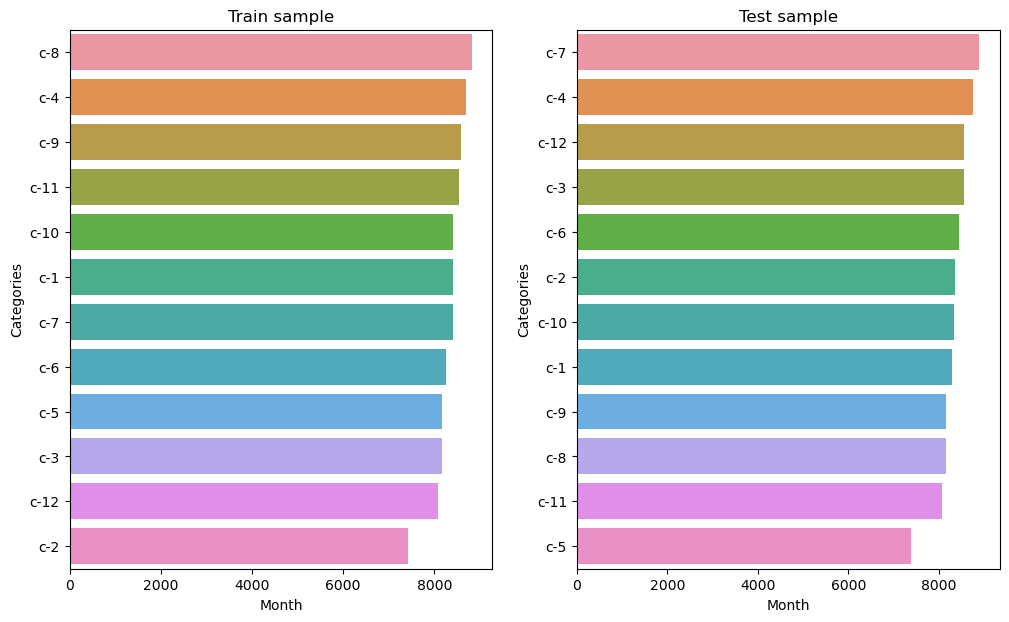

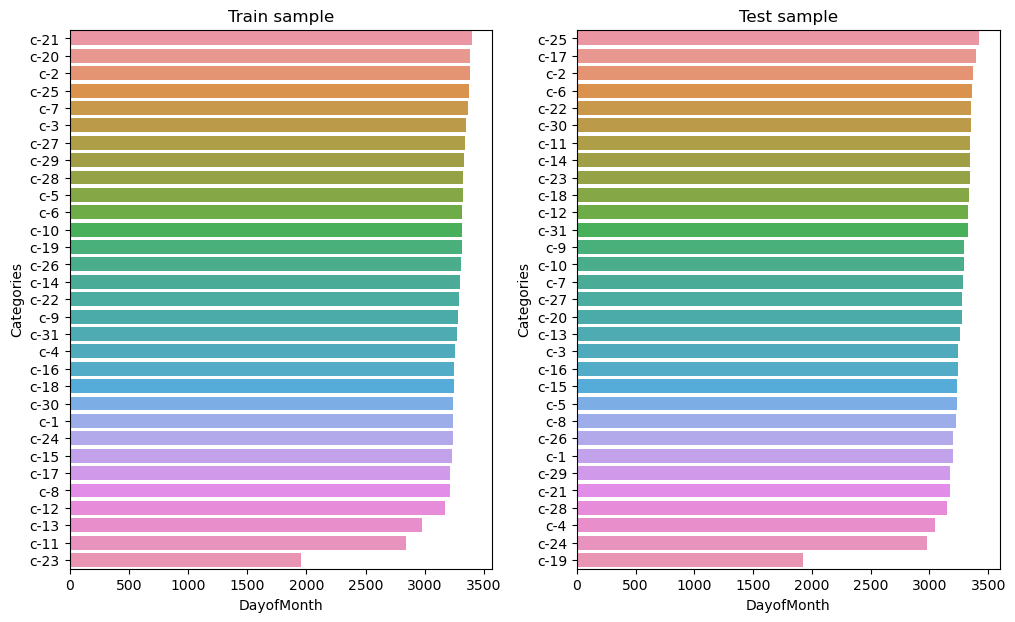

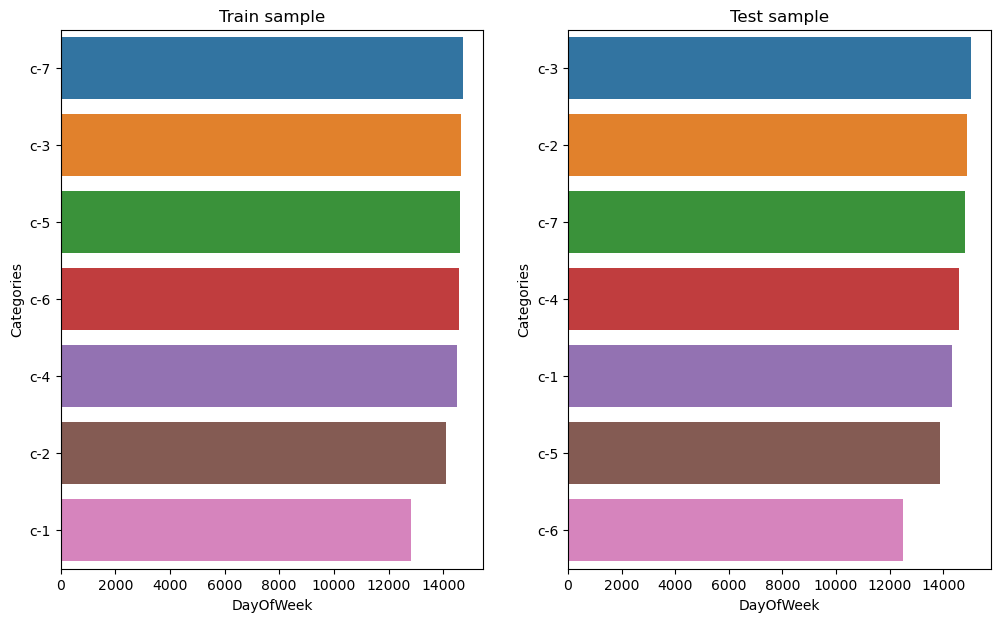

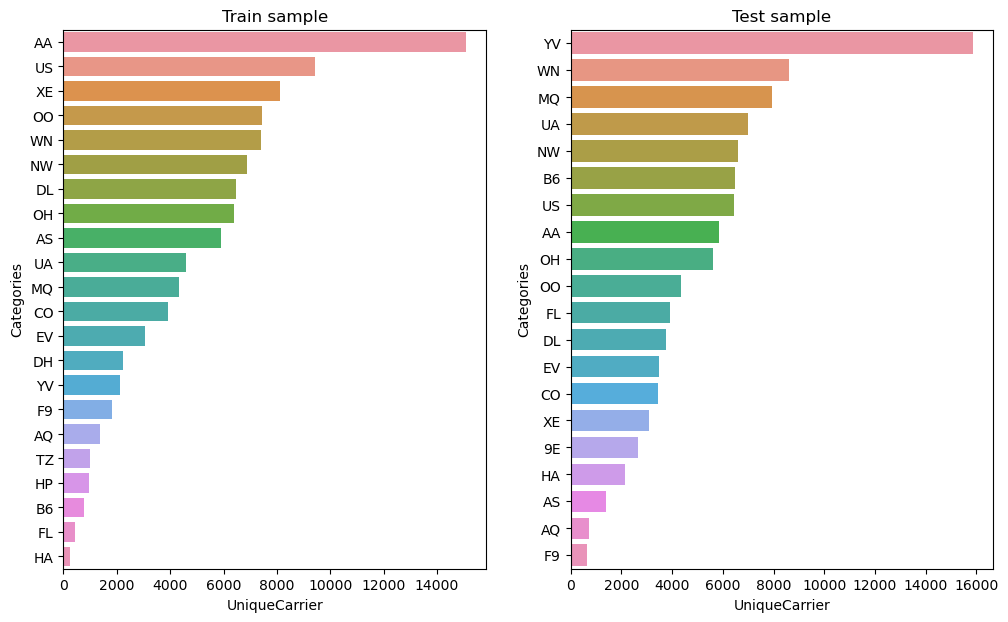

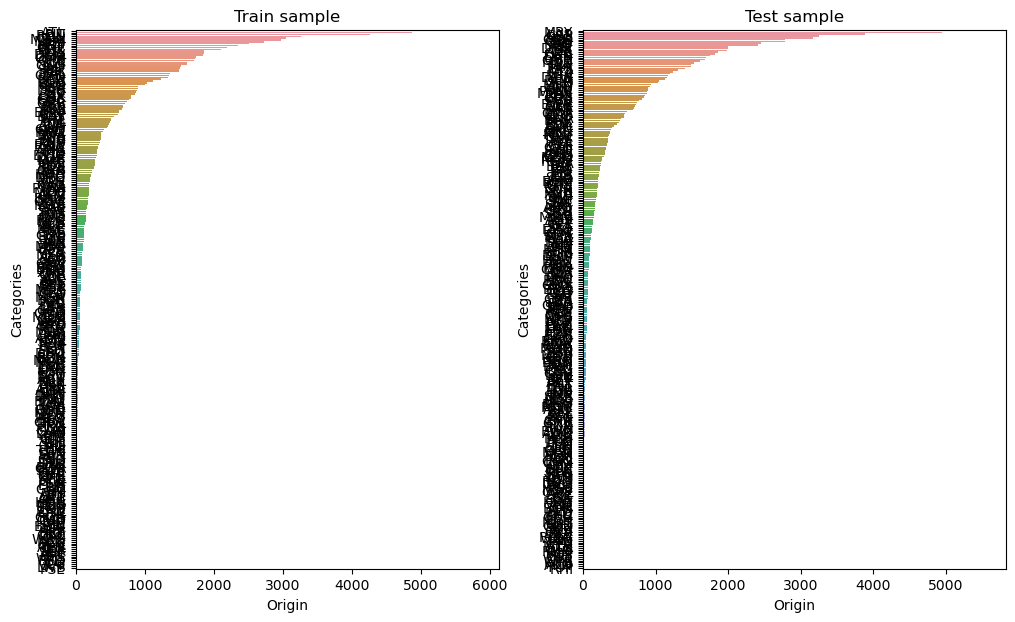

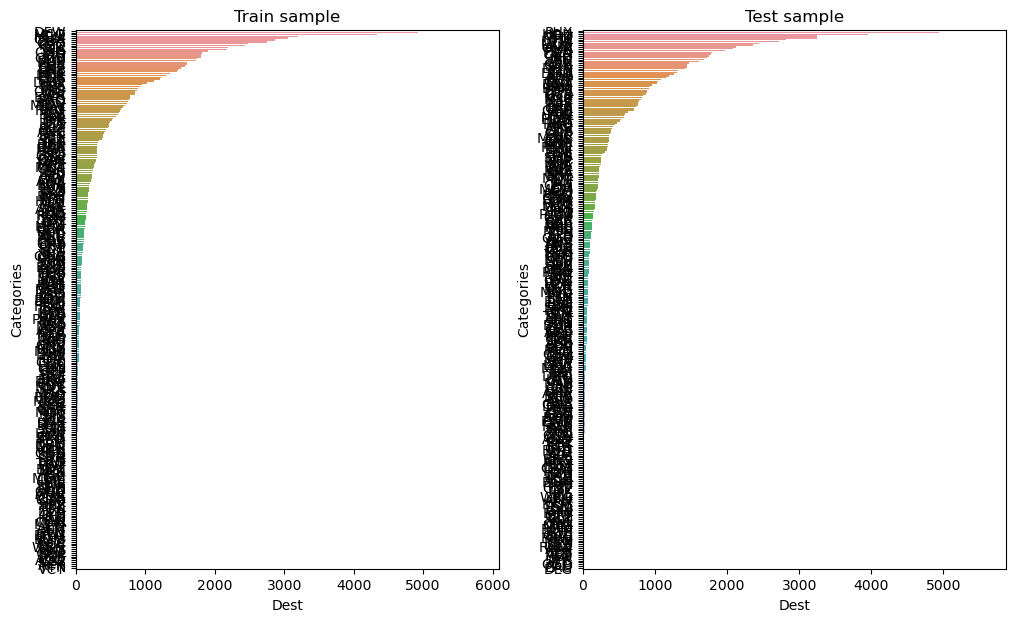

In [13]:
for col in cat_features:
    plot_obj_features(col)

Distributions of categorical features are very same (the last two categorical features are complex for visual analysis but form is distributions are matched)

In [14]:
result = {}
for col in cat_features:
    result[col] = {
        "only-train values": list(set(train[col]) - set(test[col])),
        "only-test values": list(set(test[col]) - set(train[col]))
    }

We can see that test and train samples can have unique values

In the preprocessing part we can try to drop this values for may improve model perfomance

## Numeric features

In [15]:
def plot_num_features(colname):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
    
    sns.kdeplot(data=train[colname], color='r', ax=ax, legend=True)
    sns.kdeplot(data=test[colname], color='b', ax=ax, legend=True)
    sns.set_style("whitegrid")
    
    ax.set_title(f"Train/test samples {colname}")

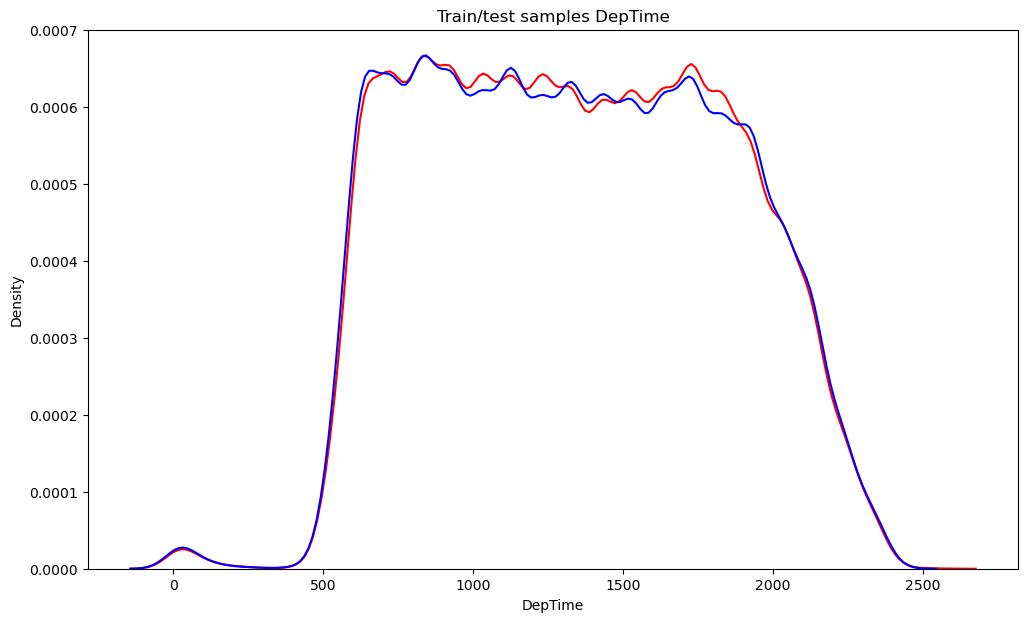

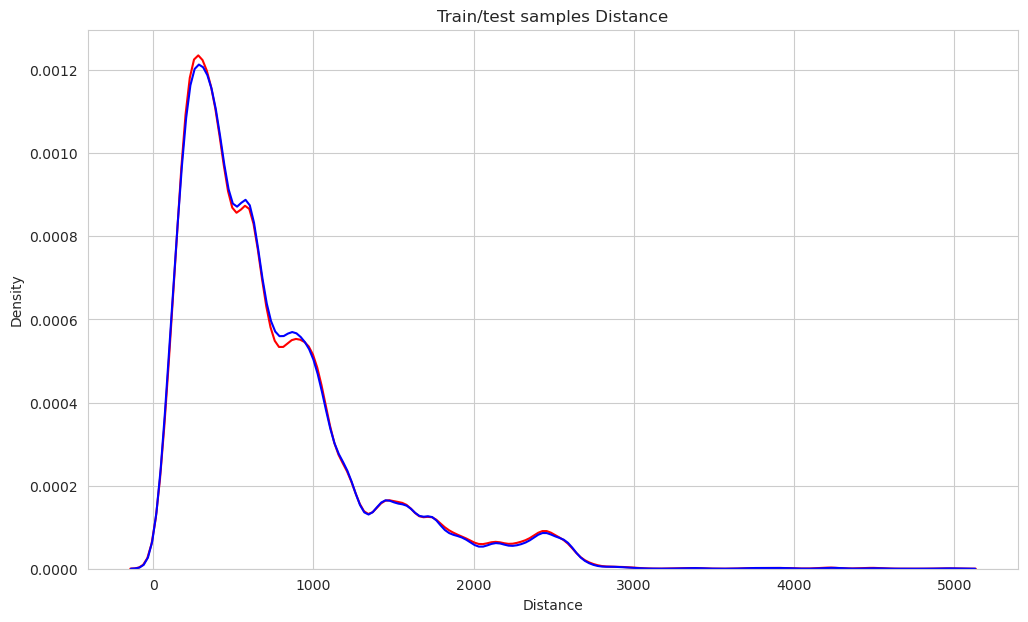

In [16]:
for col in numeric_features:
    plot_num_features(col)

We clearly see that distributhions of numeric features are also matched

These results let us for nearly unlimited freedom for preprocessing and feature generation

# Preprocessing data

Now let's try to preprocessing our data: drop unique values for train/test samples, perform categorical features into more easy-mention form

In [17]:
X = pd.concat([train.copy(), y_train.copy()], axis=1)
X_test = test.copy()

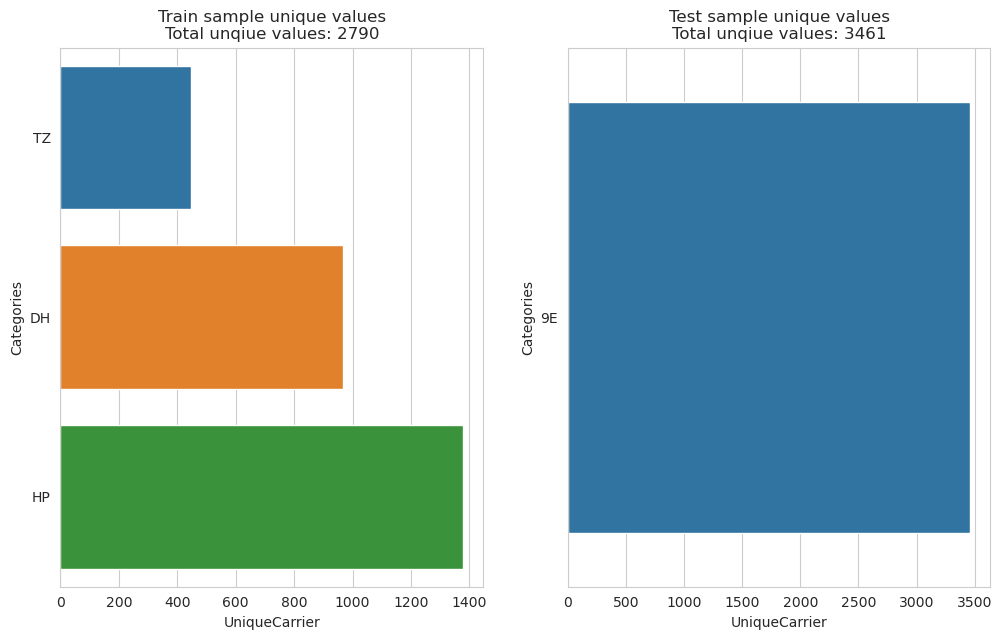

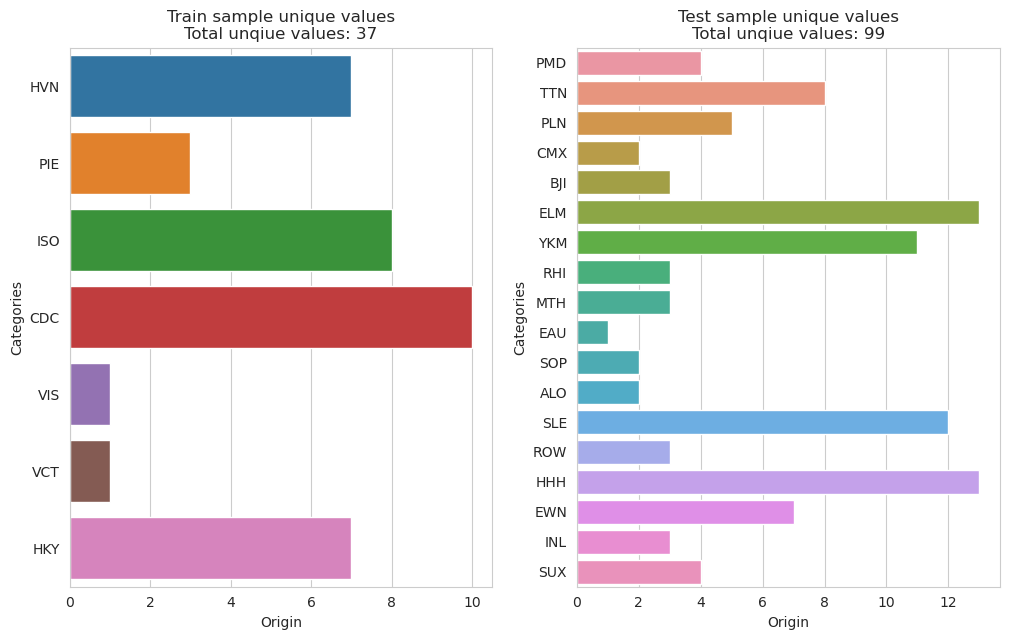

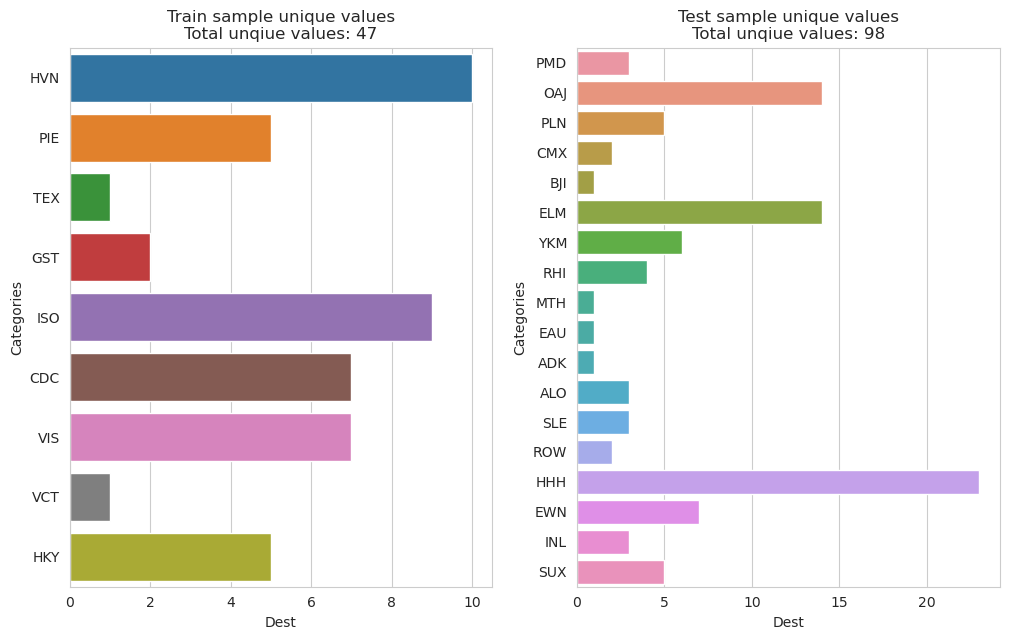

In [18]:
for col in cat_features[-3:]:
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
    first_ax, sec_ax = axs.flat
    
    sns.barplot(x=train[col].value_counts()[result[col]["only-train values"]],
                y=result[col]["only-train values"], ax=first_ax, orient="h")
    unique_values_total = np.sum(train[col].value_counts()[result[col]["only-train values"]])
    first_ax.set_title(f"Train sample unique values\nTotal unqiue values: {unique_values_total}")
    first_ax.set_xlabel(col)
    first_ax.set_ylabel("Categories")
    
    sns.barplot(x=test[col].value_counts()[result[col]["only-test values"]],
                y=result[col]["only-test values"], ax=sec_ax, orient="h")
    unique_values_total = np.sum(test[col].value_counts()[result[col]["only-test values"]])
    sec_ax.set_title(f"Test sample unique values\nTotal unqiue values: {unique_values_total}")
    sec_ax.set_xlabel(col)
    sec_ax.set_ylabel("Categories")

There isn't some connection between train/test unqiue values but also we can notice that the largest part of airports which unique for origin as well unique for dest

Despite that unique values count are different, let's try to replace all of unqiue categories to the "Unknown" label for simplify theirs structure and then check result (with such approach we try to create simply target-encoding in future)

In [19]:
def preprocessing_data(data):
    for col in cat_features[:3]:
        data[col] = data[col].apply(lambda seq: seq.replace("c-", ""))
        
    for col in cat_features[-3:]:
        pattern = '|'.join(result[col]["only-train values"])
        data[col] = data[col].apply(lambda seq: re.sub(pattern, "Unknown", seq))
        
    return data

In [20]:
X_train, X_test = preprocessing_data(train), preprocessing_data(test)

In [21]:
X_train.shape, X_test.shape

((100000, 8), (100000, 8))

# Feature Engineering

In [22]:
X = pd.concat([X_train.copy(), y_train.copy()], axis=1)
x = X_test.copy()

Rejected hypothesis: Distance flag, DepTime flag

Released hypothesis: Frequencies of airports and companies, Dist * DepTime, time-series approach to data analysis, [Company, DayofWeek, Origin, Dest] target-encoding, Holidays, Cat_features combination of the second order, Companies * Origin * Dest, deviation between mean Distance for company and observation (or median)

In [23]:
def feature_engineering(train_data, test_data):
    for col in cat_features[-3:]:
        train_frequencies = {elem: train_data[col].value_counts()[elem] / len(train_data)
                             for elem in set(train_data[col])}
        test_frequencies = {elem: test_data[col].value_counts()[elem] / len(test_data)
                             for elem in set(test_data[col])}
        
        train_data.loc[:, f"{col}_frequencies"] = train_data[col].map(train_frequencies)
        test_data.loc[:, f"{col}_frequencies"] = test_data[col].map(test_frequencies)
        
    high_depttime = train_data["DepTime"] >= 2400
    low_depttime = train_data["DepTime"] <= 430
    low_distance = train_data["Distance"] < 990
    train_data.loc[:, "is_overload"] = (high_depttime | low_depttime) & low_distance
    
    high_depttime = test_data["DepTime"] >= 2400
    low_depttime = test_data["DepTime"] <= 430
    low_distance = test_data["Distance"] < 990
    test_data.loc[:, "is_overload"] = (high_depttime | low_depttime) & low_distance
    
    for data in (train_data, test_data):
        time_series = pd.DataFrame(data.groupby(["Month", "DayofMonth"]).count()["Dest"].reset_index())
        time_series["date"] = pd.to_datetime(dict(year=2022,
                                          month=time_series["Month"], day=time_series["DayofMonth"]))
        time_series = time_series.drop(["Month", "DayofMonth"], axis=1)
        time_series.columns = ["count", "ds"]
        
        deviation = np.std(time_series["count"] - np.mean(time_series["count"]))
        lower_bound = np.mean(time_series["count"]) - 1.96 * deviation
        upper_bound = np.mean(time_series["count"]) + 1.96 * deviation
        anomalies = pd.concat([time_series[time_series["count"] <= lower_bound],
                       time_series[time_series["count"] >= upper_bound]], axis=0)["ds"]
        
        temp = pd.to_datetime(dict(year=2022, month=data["Month"], day=data["DayofMonth"]))
        data["is_anomaly"] = [1 if date in set(anomalies) else 0 for date in temp]
        
    for col in cat_features[-4:]:
        if col != "DayOfWeek":
            temp = train_data.groupby(col).agg(np.sum)['dep_delayed_15min'] / len(train_data)
            tempp = {ind: temp[ind] for ind in temp.index}
            train_data[f"target_coding_{col}"] = train_data[col].map(tempp)
            train_data[f"target_coding_{col}"] = train_data[f"target_coding_{col}"] / train_data[f"{col}_frequencies"]
        
            tempp = {key: tempp[key] / train_data[train_data[col] == key][f"{col}_frequencies"].reset_index().iloc[0, 1]
                     for key in tempp.keys()}
            test_data[f"target_coding_{col}"] = test_data[col].map(tempp)
        
        else:
            train_frequencies = {elem: train_data[col].value_counts()[elem] / len(train_data)
                             for elem in set(train_data[col])}
            temp = train_data.groupby(col).agg(np.sum)['dep_delayed_15min'] / len(train_data)
            tempp = {ind: temp[ind] for ind in temp.index}
            
            tempp = {key: tempp[key] / train_frequencies[key] for key in tempp.keys()}
            train_data[f"target_coding_{col}"] = train_data[col].map(tempp)
            test_data[f"target_coding_{col}"] = test_data[col].map(tempp)
            
    for data in (train_data, test_data):
        data["date"] = pd.to_datetime(dict(year=2022, month=data["Month"], day=data["DayofMonth"]))
        hd = holidays.UnitedKingdom()
        hd = {date: int(hd.get(key=date) is not None) for date in time_series["ds"]}
        data["is_holiday"] = data["date"].map(hd)
        
#     for first_col in cat_features[-4:]:
#         for second_col in cat_features[-4:]:
#             if second_col != first_col:
#                 if f"target_coding_{first_col} & {second_col}" in train_data.columns:
#                     break
                    
#                 temp = train_data.copy().groupby([first_col, second_col]).agg(np.sum)["dep_delayed_15min"].reset_index()
#                 temp[f"{first_col} & {second_col}"] = temp[first_col] + temp[second_col]
#                 temp = temp.drop([first_col, second_col], axis=1)
#                 group_counts = (train_data[first_col] + train_data[second_col]).value_counts()
#                 temp = temp.set_index(f"{first_col} & {second_col}").iloc[:, 0]
#                 map_scheme = {elem: temp[elem] / group_counts[elem] for elem in set(group_counts.index)}
                
#                 train_data[f"target_coding_{first_col} & {second_col}"] = train_data[first_col] + train_data[second_col]
#                 test_data[f"target_coding_{first_col} & {second_col}"] = test_data[first_col] + test_data[second_col]
#                 train_data[f"target_coding_{first_col} & {second_col}"] = train_data[f"target_coding_{first_col} & {second_col}"].map(map_scheme)
#                 test_data[f"target_coding_{first_col} & {second_col}"] = test_data[f"target_coding_{first_col} & {second_col}"].map(map_scheme)
            
#     temp = train_data.copy().groupby(["UniqueCarrier", "Origin", "Dest"]).agg(np.sum).reset_index()
#     temp = temp.drop(["DepTime", "Distance"], axis=1)
#     temp["UniqueCarrier & Origin & Dest"] = temp["UniqueCarrier"] + temp["Origin"] + temp["Dest"]
#     temp = temp.drop(["UniqueCarrier", "Origin", "Dest"], axis=1)
#     temp = temp.set_index("UniqueCarrier & Origin & Dest")["dep_delayed_15min"]

#     groups_count = (train_data["UniqueCarrier"] + train_data["Origin"] + train_data["Dest"]).value_counts()
#     map_scheme = {elem: temp[elem] / groups_count[elem] for elem in set(groups_count.index)}
    
#     train_data["target_coding_UniqueCarrier & Origin & Dest"] = train_data["UniqueCarrier"] + train_data["Origin"] + train_data["Dest"]
#     test_data["target_coding_UniqueCarrier & Origin & Dest"] = test_data["UniqueCarrier"] + test_data["Origin"] + test_data["Dest"]
#     train_data["target_coding_UniqueCarrier & Origin & Dest"] = train_data["target_coding_UniqueCarrier & Origin & Dest"].map(map_scheme)
#     test_data["target_coding_UniqueCarrier & Origin & Dest"] = test_data["target_coding_UniqueCarrier & Origin & Dest"].map(map_scheme)
    
    for data in (train_data, test_data):
        temp = data.copy().groupby("UniqueCarrier").agg(np.mean).reset_index()
        if "dep_delayed_15min" in data.columns:
            temp = temp.drop(["DepTime", "dep_delayed_15min"], axis=1).set_index("UniqueCarrier")["Distance"]
        else:
            temp = temp.drop("DepTime", axis=1).set_index("UniqueCarrier")["Distance"]
        mean_deviation = {elem: temp[elem] for elem in set(temp.index)}
        data["mean_distance_deviation"] = data["UniqueCarrier"].map(mean_deviation)
        data["mean_distance_deviation"] = data["Distance"] - data["mean_distance_deviation"]
        
        temp = data.copy().groupby("UniqueCarrier").agg(np.median).reset_index()
        if "dep_delayed_15min" in data.columns:
            temp = temp.drop(["DepTime", "dep_delayed_15min"], axis=1).set_index("UniqueCarrier")["Distance"]
        else:
            temp = temp.drop("DepTime", axis=1).set_index("UniqueCarrier")["Distance"]
        median_deviation = {elem: temp[elem] for elem in set(temp.index)}
        data["median_distance_deviation"] = data["UniqueCarrier"].map(median_deviation)
        data["median_distance_deviation"] = data["Distance"] - data["median_distance_deviation"]
    
    return train_data, test_data

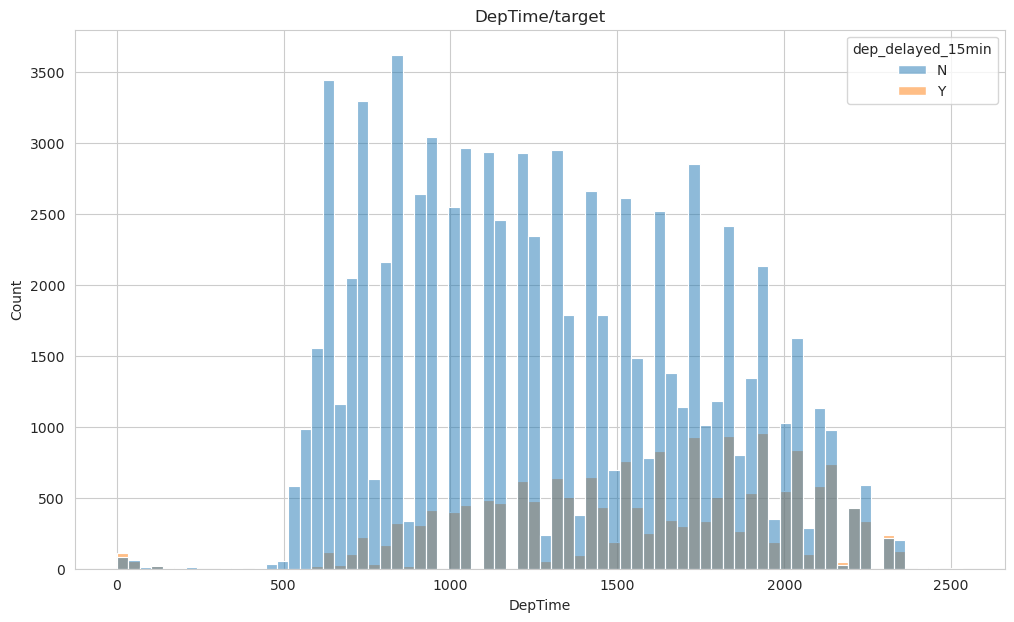

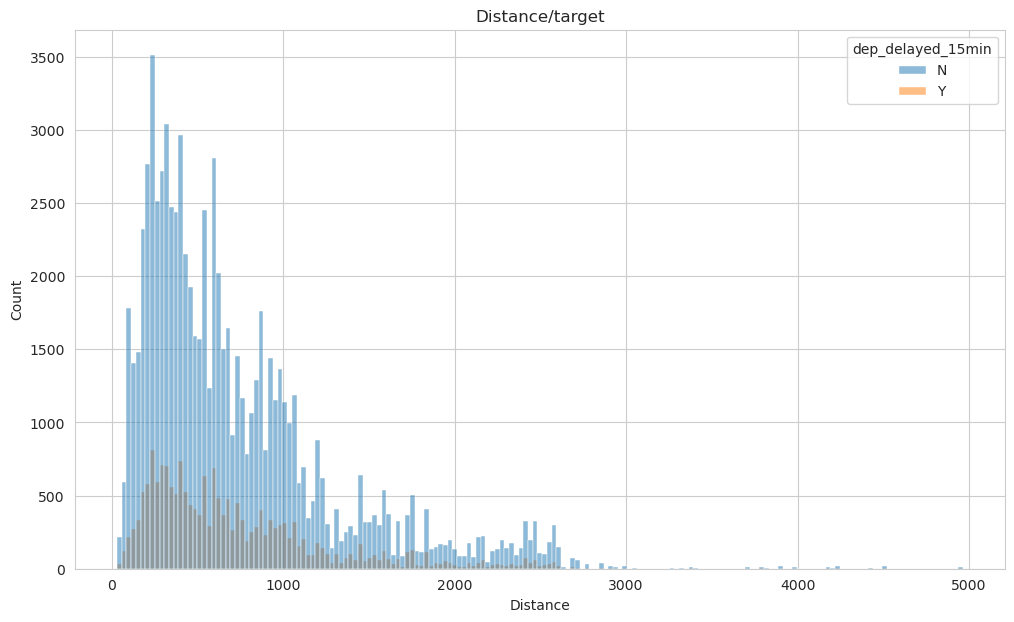

In [24]:
for col in numeric_features:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
    
    sns.histplot(data=X, x=X[col], ax=ax, hue=y_train)
    sns.set_style("whitegrid")
    
    ax.set_title(f"{col}/target")

As we can see there isn't seeable correlation between numeric features and target, so threshold flags can't help in this case

Generate new feature: is_holiday flag which signalized this day is holiday or not

Count frequencies for all airports (origin/dept) because it can influence on the delay time

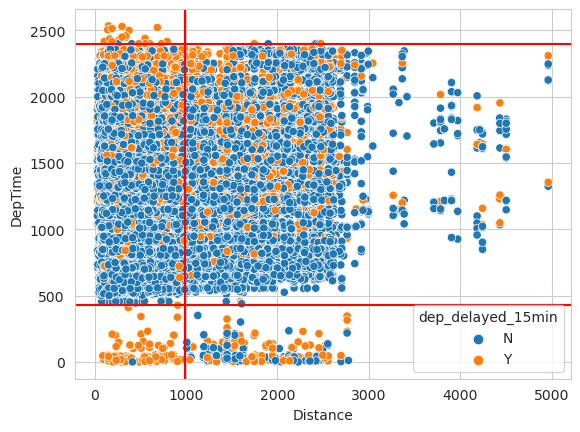

In [25]:
graph = sns.scatterplot(data=X, x="Distance", y="DepTime", hue=y_train)
graph.axhline(2400, color="red")
graph.axvline(990, color="red")
graph.axhline(430, color="red")

By means of this grafic we can se that more of flights with low DepTime (under 500) and Distance between 0 and 1000 and flights with same distance and the highest DepTime is very often to delay.

Let's try to time series approach to data analysis: let's check how to the counts of flights depends on time.

For working we initial the year for dates (for example 2022) and finally we get time-series with dates of depart and counts of fly

In [26]:
time_series = pd.DataFrame(X.groupby(["Month", "DayofMonth"]).count()["Dest"].reset_index())
time_series
time_series["date"] = pd.to_datetime(dict(year=2022,
                                          month=time_series["Month"], day=time_series["DayofMonth"]))
time_series = time_series.drop(["Month", "DayofMonth"], axis=1)
time_series.columns = ["count", "ds"]
time_series.head()

,count,ds
0,243,2022-01-01
1,284,2022-01-10
2,236,2022-01-11
3,247,2022-01-12
4,251,2022-01-13


Let's plot time series for analysis

<Axes: xlabel='ds'>

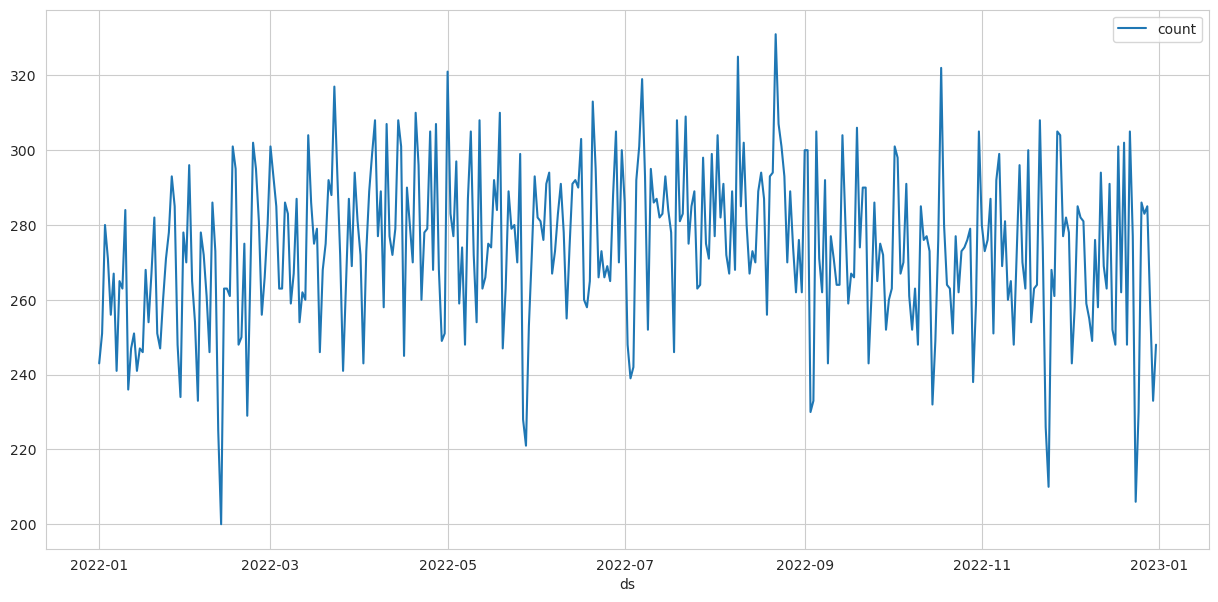

In [27]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=time_series.set_index("ds"))

Now let's try to detect anomalies (if they are) and add boolean flag is_ anomaly by the mean of these actions (available deviation: 1.96 * mae for 95% level)

<Axes: xlabel='ds'>

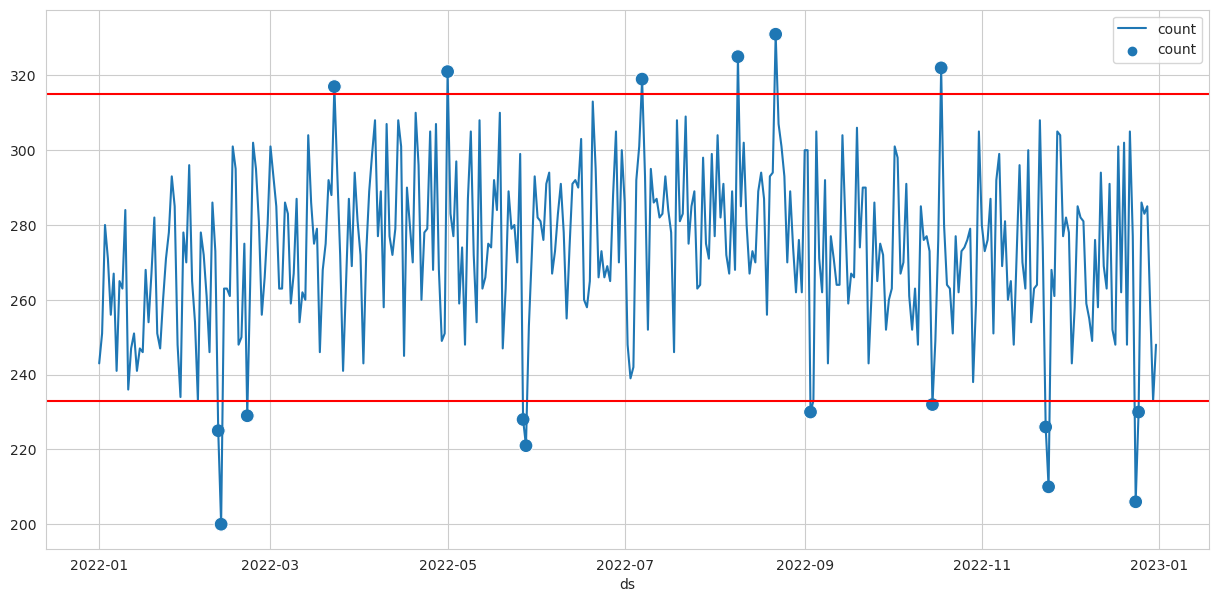

In [28]:
plt.figure(figsize=(15, 7))
deviation = np.std(time_series["count"] - np.mean(time_series["count"]))
graph = sns.lineplot(data=time_series.set_index("ds"))
lower_bound = np.mean(time_series["count"]) - 1.96 * deviation
upper_bound = np.mean(time_series["count"]) + 1.96 * deviation
graph.axhline(lower_bound, color="red")
graph.axhline(upper_bound, color="red")
anomalies = pd.concat([time_series[time_series["count"] <= lower_bound],
                       time_series[time_series["count"] >= upper_bound]], axis=0)
sns.scatterplot(data=anomalies.set_index("ds"), c="red", s=100)

We successfully detected possible anomalies!

In [29]:
X_train, X_test = feature_engineering(pd.concat([X_train, y_train.map({"N":0, "Y":1})], axis=1), X_test)

In [30]:
X_train.shape, X_test.shape

((100000, 22), (100000, 21))

In [31]:
X_train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,UniqueCarrier_frequencies,...,is_overload,is_anomaly,target_coding_DayOfWeek,target_coding_UniqueCarrier,target_coding_Origin,target_coding_Dest,date,is_holiday,mean_distance_deviation,median_distance_deviation
0,8,21,7,1934,AA,ATL,DFW,732,0,0.09418,...,False,0,0.191885,0.187938,0.258142,0.151257,2022-08-21,0,-347.926630,-285.0
1,4,20,3,1548,US,PIT,MCO,834,0,0.06482,...,False,0,0.176937,0.167387,0.171512,0.184028,2022-04-20,0,86.712434,288.0
2,9,2,5,1422,XE,RDU,CLE,416,0,0.05901,...,False,0,0.224125,0.173869,0.184332,0.175698,2022-09-02,0,-114.383664,-34.0
3,11,25,6,1015,OO,DEN,MEM,872,0,0.07390,...,False,0,0.167199,0.172801,0.193407,0.149444,2022-11-25,0,485.692558,543.0
4,10,7,6,1828,WN,MDW,OMA,423,1,0.15082,...,False,0,0.167199,0.213433,0.251098,0.260450,2022-10-07,0,-197.371171,0.0


In [32]:
X_train["is_overload"], X_test["is_overload"] = X_train["is_overload"].astype(int), X_test["is_overload"].astype(int)
X_train, X_test = X_train.drop("date", axis=1), X_test.drop("date", axis=1)

# XGBClassifier

Split train sample on the train and holdout smaples

In [33]:
train = X_train.copy()
X_train, X_holdout, y_train, y_holdout = train_test_split(train.drop([*cat_features, 'dep_delayed_15min'], axis=1),
                                                         train['dep_delayed_15min'], test_size=.33,
                                                         shuffle=True, random_state=17, stratify=train["dep_delayed_15min"])
X_train

,DepTime,Distance,UniqueCarrier_frequencies,Origin_frequencies,Dest_frequencies,is_overload,is_anomaly,target_coding_DayOfWeek,target_coding_UniqueCarrier,target_coding_Origin,target_coding_Dest,is_holiday,mean_distance_deviation,median_distance_deviation
98472,635,324,0.15082,0.00112,0.00655,0,0,0.190404,0.213433,0.142857,0.145038,0,-296.371171,-99.0
94650,1359,429,0.05901,0.03048,0.00301,0,0,0.211523,0.173869,0.161417,0.202658,0,-101.383664,-21.0
94466,1725,134,0.07443,0.04270,0.00072,0,0,0.190404,0.194545,0.211241,0.125000,0,-273.228940,-208.0
16093,1112,588,0.07443,0.00169,0.04933,0,0,0.224125,0.194545,0.171598,0.217312,0,180.771060,246.0
48415,815,106,0.04594,0.05834,0.00058,0,0,0.224125,0.175882,0.258142,0.189655,0,-356.688289,-313.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98378,700,256,0.15082,0.02729,0.02475,0,0,0.190404,0.213433,0.179919,0.210101,0,-364.371171,-167.0
49190,1721,748,0.05901,0.02196,0.00847,0,0,0.190404,0.173869,0.244991,0.198347,0,217.616336,298.0
3584,2038,296,0.07443,0.04870,0.00497,0,0,0.191885,0.194545,0.257495,0.205231,0,-111.228940,-46.0
1528,1029,185,0.08128,0.01737,0.01803,0,0,0.191885,0.168922,0.201497,0.201886,0,-703.395423,-445.0


In [34]:
def plot_curves(params, X_train, X_holdout, y_train, y_holdout):
    fig, axs = plt.subplots(nrows=len(params.keys()), ncols=1, figsize=(12, 9))
    roc_auc = []
    key_ind = 0
    
    for param in params.keys():
        for val in params[param]:
            if param == "learninig_rate":
                model = XGBClassifier(learning_rate=val, objective="binary:logistic",
                                      eval_metric="auc", verbose=0)
            elif param == "max_depth":
                model = XGBClassifier(max_depth=int(val), objective="binary:logistic",
                                      eval_metric="auc", verbose=0)
            else:
                model = XGBClassifier(n_estimators=int(val), objective="binary:logistic",
                                      eval_metric="auc", verbose=0)
            model.fit(X_train, y_train)
            
            y_pred = model.predict(X_holdout)
            if np.sum(y_pred) != 0:
                roc_auc.append(roc_auc_score(y_pred, y_holdout))
            else:
                roc_auc.append(0)
        
        ax = axs.flat[key_ind]
        
        sns.lineplot(x=params[param], y=roc_auc, ax=ax)
        ax.set_title("Validation curve")
        ax.set_xlabel(param)
        ax.set_ylabel("ROC_AUC")
        
        roc_auc = []
        key_ind += 1

In [35]:
# params = {
#     'learning_rate': np.logspace(-2, -1, 7),
#     'max_depth': np.linspace(5, 9, 5).astype(int),
#     'n_estimators': np.linspace(100, 400, 7).astype(int)
# }

In [36]:
# plot_curves(params, X_train.drop([*drop_columns, *cols[11:]], axis=1),
#             X_holdout.drop([*drop_columns, *cols[11:]], axis=1), y_train, y_holdout)

In [37]:
# search = GridSearchCV(XGBClassifier(), param_grid=params, scoring="roc_auc",
#                      cv=5, verbose=0)
# search.fit(train.drop([*cat_features, 'dep_delayed_15min'], axis=1), train['dep_delayed_15min'])

In [38]:
# search.cv_results_

In [39]:
# search.best_score_, search.best_params_

## Feature Selection

In [40]:
clf = XGBClassifier(learning_rate=0.068, max_depth=9, n_estimators=400,
                   objective="binary:logistic", eval_metric="auc")

clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.068, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [41]:
importances = {X_train.columns[i]: clf.feature_importances_[i] for i in range(len(X_train.columns))}
importances = dict(sorted(importances.items(), key=lambda item: item[1], reverse=True))
drop_columns = [key for key in importances.keys() if importances[key] == 0]
cols = [key for key in importances.keys() if key not in drop_columns]

Text(0, 0.5, 'ROC - AUC')

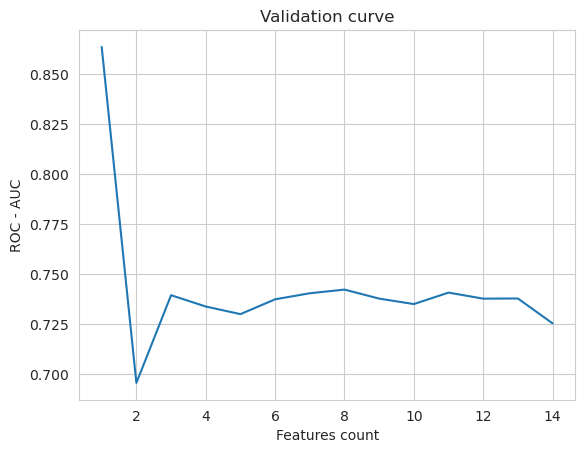

In [42]:
roc_auc = []
xticks = np.arange(1, len(cols) + 1)

for i in range(len(cols)):
    clf = XGBClassifier(learning_rate=0.068, max_depth=9, n_estimators=400,
                   objective="binary:logistic", eval_metric="auc")
    clf.fit(X_train.drop([*drop_columns, *cols[i+1:]], axis=1), y_train)
    y_pred = clf.predict(X_holdout.drop([*drop_columns, *cols[i+1:]], axis=1))
    
    roc_auc.append(roc_auc_score(y_pred, y_holdout))

sns.lineplot(x=xticks, y=roc_auc)
plt.title("Validation curve")
plt.xlabel("Features count")
plt.ylabel("ROC - AUC")

# Predictions

In [43]:
clf = XGBClassifier(learning_rate=0.068, max_depth=9, n_estimators=400,
                   objective="binary:logistic", eval_metric="auc")
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test.drop([*cat_features, *drop_columns], axis=1))

submission["dep_delayed_15min"] = y_pred[:, 1]
submission.to_csv("/kaggle/working/submission.csv", index=False)